## Вопросы

ВЫЯСНИЛИ почему не получается логарифмировать ряд - Либо заменить на средние, либо на моду

???Почему графики корреляций на всех значениях кроме исходного ряда показывают такие странные значения

ПОКА НЕТ откуда возникают сингулярные матрицы - добавить простые алгоритмы, а по тюнингу параметров особо не мучиться

ПОКА НЕТ почему в box-cox не берутся нули

ВЫЯСНИЛИ может быть ряд стоит зашумить - сейчас расчет сделан на основе LFL магазинов, а не общего количества. ради реальности можно, например сделать поправочный коэффициент на рост сети/рост дистрибуции - в целом, LFL ок, но можно попробовать на других алгоритмах, которые не SARIMA

ПОКА НЕТиз классических инструментов временных рядов может быть попробовать еще Prophet?

ПОКА НЕТ непонятно что подавать на вход в нейронных сетях

РЕШИЛИ ЧТО МОЖНО ЕЩЕ ПОКРУТИТЬ деревья решений сделал по аналогии из статьи - ничего не получилось, предсказание просто по среднему хуже деревьев процентов на 25%

в деревья добавить категорийные фичи - меньше 100, 100-200 и т.д.

# Классические методы временных рядов

## импорты

In [3]:
import pandas as pd


import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller

import datetime
from dateutil.relativedelta import relativedelta

from arch import arch_model

p = print

C:\Pythonn\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
%matplotlib inline

In [5]:
df = pd.read_csv('df')

## функции графиков рядов

In [6]:
df.head()

,ind,dates,sales,AUP_RUR,AUP_RUR_RRP,AUP+bonus
0,1,2012-09-09,23,5658.513739,9619.448357,6612.109391
1,2,2012-09-16,10,6065.175200,10238.858811,6762.978200
2,3,2012-09-23,9,5876.925926,9058.186700,6231.744815
3,4,2012-09-30,4,5319.947500,9415.000000,6163.250000
4,5,2012-10-07,4,6731.930000,9415.000000,6807.750000


In [7]:
def tsplot(y, win, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    rolmean = y.rolling(window=win).mean()
    rolstd = pd.rolling_std(y, window=win)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        rolmean.plot(ax=ts_ax, color='red')
        rolstd.plot(ax=ts_ax, color='black')
        ts_ax.set_title('Original(blue), Rolling Mean(red) & Standard Deviation(black)')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')

        plt.tight_layout()
    return

In [8]:
def seasonal_decompose_plot(y,  freq=None):
    if not isinstance(y, pd.Series): # не является рядом?
        y = pd.Series(y) # преобразовать в ряд

    decomposition = seasonal_decompose(Y, freq=freq)
    # fig = plt.figure()
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)
    return

In [9]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dftest[0] > dftest[4]['5%']:
        print ('ряд не стационарен')
    else:
        print ('ряд стационарен')

In [10]:
def arima_best_order(timeseries):
    max_lag = 30
    best_aic = np.inf
    best_order = None
    best_mdl = None
    pq_rng = range(5)  # [0,1,2,3,4]
    d_rng = range(2)  # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(timeseries, order=(i, d, j)).fit(maxlag=max_lag, method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_mdl

## загрузка и подготовка, предобработка данных

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 6 columns):
ind            309 non-null int64
dates          309 non-null object
sales          309 non-null int64
AUP_RUR        309 non-null float64
AUP_RUR_RRP    309 non-null float64
AUP+bonus      309 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 14.6+ KB


### Визуализация

In [12]:
df.head()

,ind,dates,sales,AUP_RUR,AUP_RUR_RRP,AUP+bonus
0,1,2012-09-09,23,5658.513739,9619.448357,6612.109391
1,2,2012-09-16,10,6065.175200,10238.858811,6762.978200
2,3,2012-09-23,9,5876.925926,9058.186700,6231.744815
3,4,2012-09-30,4,5319.947500,9415.000000,6163.250000
4,5,2012-10-07,4,6731.930000,9415.000000,6807.750000


In [13]:
# *15 - чтобы получить приблизительно одинаковый масштаб данных продаж и цен
df['sales1'] = df['sales']*15

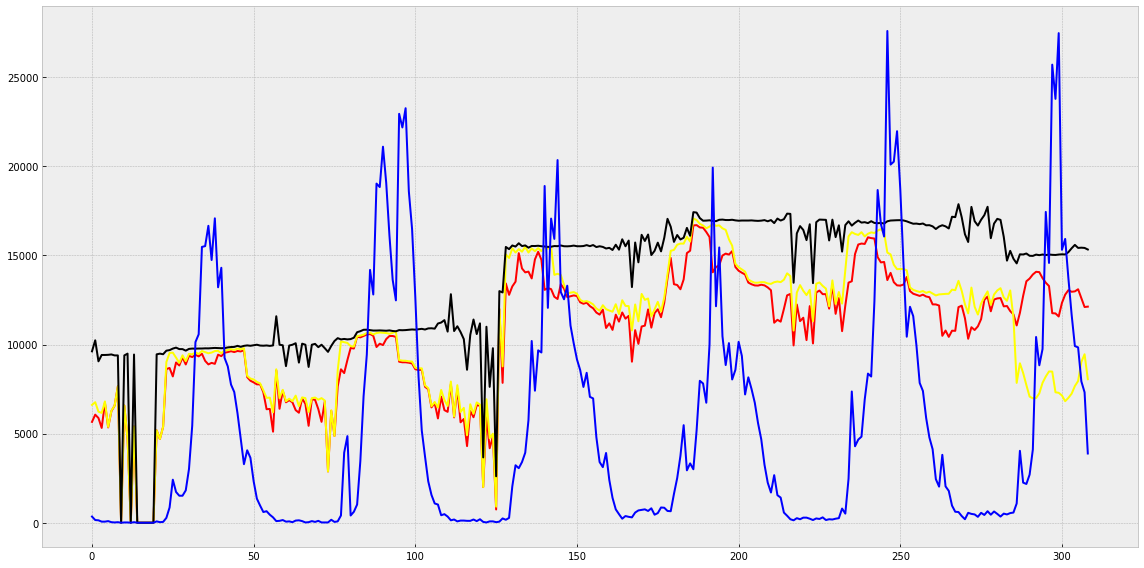

In [14]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    df['AUP_RUR'].plot(color='red')
    df['AUP+bonus'].plot(color='yellow')
    df['AUP_RUR_RRP'].plot(color='black')
    df['sales1'].plot(color = "blue")
    plt.tight_layout()

### преобразуем даты в формат datetime

In [15]:
# Загрузим данные
df.index.name=None
df.reset_index(inplace=True)

In [16]:
#  Укажем формат времени
start = datetime.datetime.strptime("2012-09-09", "%Y-%m-%d")
date_list = [start + relativedelta(weeks=x) for x in range(0,len(df.sales))]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

In [17]:
df.head()

,ind,dates,sales,AUP_RUR,AUP_RUR_RRP,AUP+bonus,sales1
2012-09-09,1,2012-09-09,23,5658.513739,9619.448357,6612.109391,345
2012-09-16,2,2012-09-16,10,6065.175200,10238.858811,6762.978200,150
2012-09-23,3,2012-09-23,9,5876.925926,9058.186700,6231.744815,135
2012-09-30,4,2012-09-30,4,5319.947500,9415.000000,6163.250000,60
2012-10-07,5,2012-10-07,4,6731.930000,9415.000000,6807.750000,60


### рисуем графики ряда, AR, APR

сезон - 52 недели. но т.к. по факту, присутствуют два явных паттерна - полный ноль и продажи, используем так же и 26 недель

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=52,center=False).std()
  """


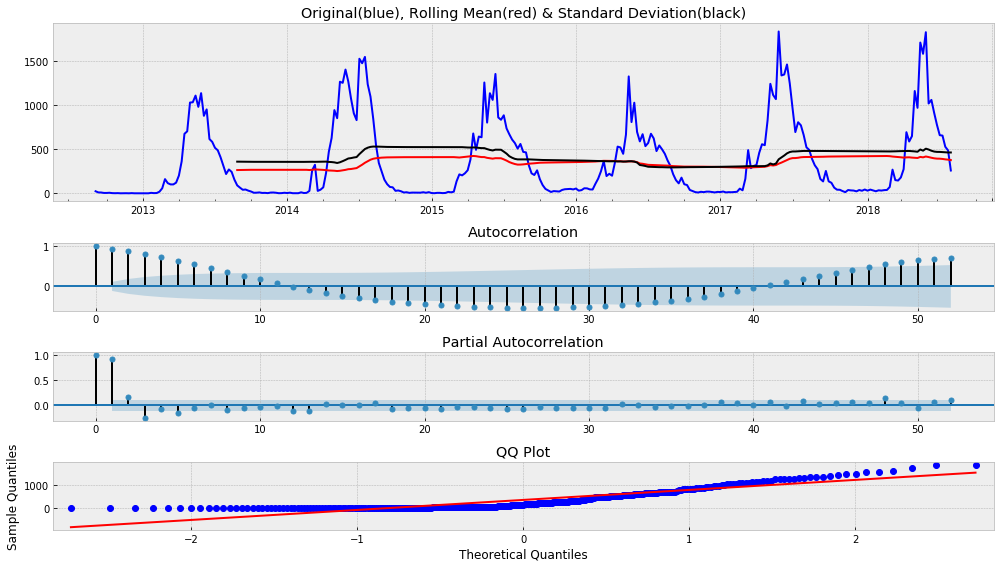

In [18]:
#df['Sales_U'] = df.Sales_U.apply(lambda x: int(x)*100)
tsplot(df.sales, win=52, lags=52)

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).std()
  """


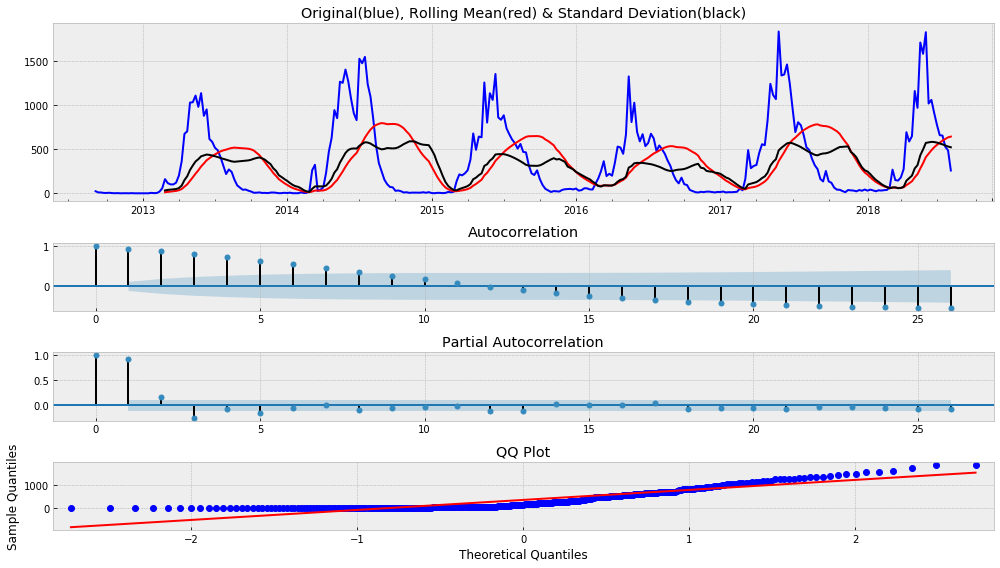

In [19]:
#df['Sales_U'] = df.Sales_U.apply(lambda x: int(x)*100)
tsplot(df.sales, win=26, lags=26)

декомпозицию также построили по двум периодам, видим, что остатки при 52 все же менее системные

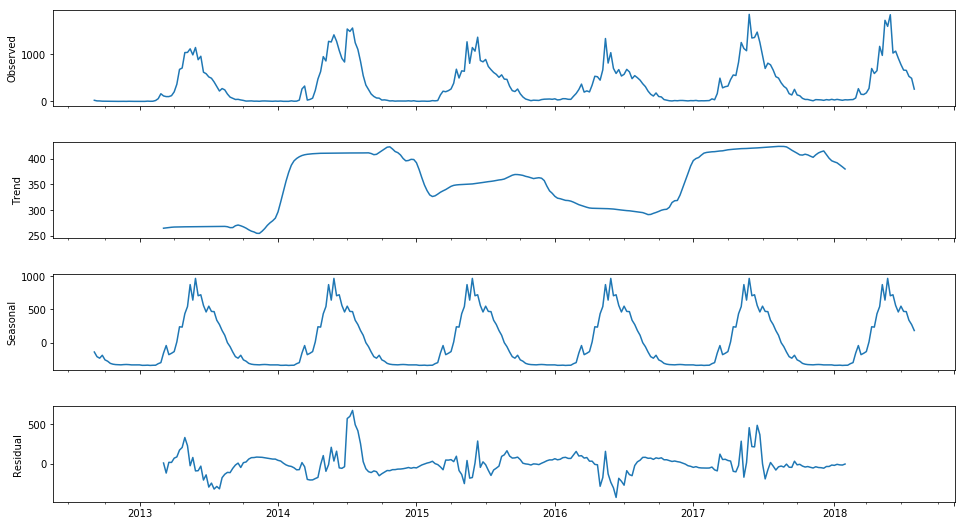

In [20]:
decomposition = seasonal_decompose(df.sales, freq=52)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

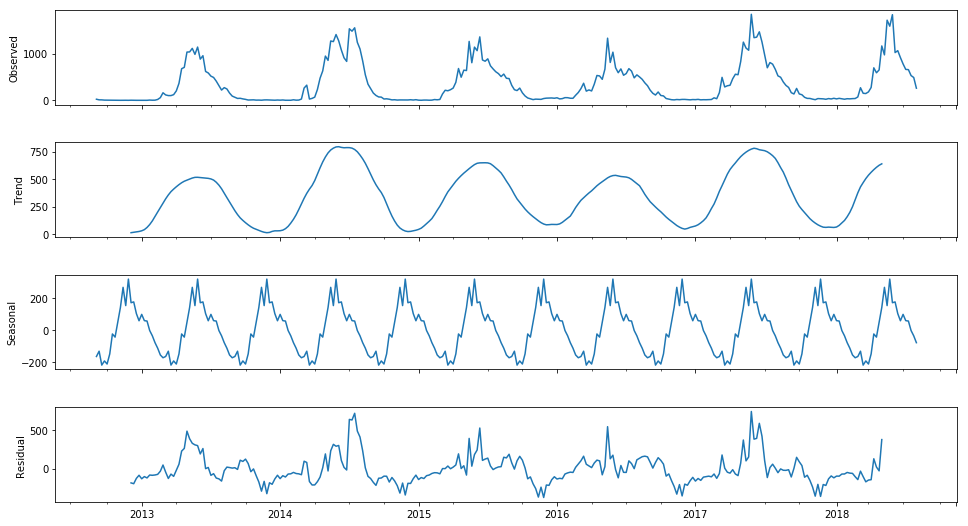

In [21]:
decomposition = seasonal_decompose(df.sales, freq=26)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

## проверка на стационарность

### собственно, тест

In [22]:
test_stationarity(df.sales)

Results of Dickey-Fuller Test:
Test Statistic                -5.869214e+00
p-value                        3.270257e-07
#Lags Used                     1.200000e+01
Number of Observations Used    2.960000e+02
Critical Value (1%)           -3.452637e+00
Critical Value (5%)           -2.871354e+00
Critical Value (10%)          -2.571999e+00
dtype: float64
ряд стационарен


даже наш исходный ряд стационарен, но, т.к. в остатках все же есть какое-то подобие структуры, попробуем продифференцировать  исходный ряд на 1, 26 и 52 периодов и первый дифференциал еще на 26 и 52

In [23]:
df['first_difference'] = df.sales.diff(periods = 1).dropna()
test_stationarity(df.first_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -6.848082e+00
p-value                        1.722165e-09
#Lags Used                     3.000000e+00
Number of Observations Used    3.040000e+02
Critical Value (1%)           -3.452045e+00
Critical Value (5%)           -2.871095e+00
Critical Value (10%)          -2.571861e+00
dtype: float64
ряд стационарен


In [24]:
df['half_seasonal_difference'] = df.sales.diff(periods = 26).dropna()
test_stationarity(df.half_seasonal_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -6.010700e+00
p-value                        1.576044e-07
#Lags Used                     1.500000e+01
Number of Observations Used    2.670000e+02
Critical Value (1%)           -3.455081e+00
Critical Value (5%)           -2.872427e+00
Critical Value (10%)          -2.572571e+00
dtype: float64
ряд стационарен


In [25]:
df['half_seasonal_first_difference'] = df.first_difference.diff(periods = 26).dropna()
test_stationarity(df.half_seasonal_first_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                  -4.594179
p-value                          0.000132
#Lags Used                      15.000000
Number of Observations Used    266.000000
Critical Value (1%)             -3.455175
Critical Value (5%)             -2.872468
Critical Value (10%)            -2.572593
dtype: float64
ряд стационарен


In [26]:
df['seasonal_difference'] = df.sales.diff(periods = 52).dropna()
test_stationarity(df.seasonal_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                  -4.982451
p-value                          0.000024
#Lags Used                       2.000000
Number of Observations Used    254.000000
Critical Value (1%)             -3.456360
Critical Value (5%)             -2.872987
Critical Value (10%)            -2.572870
dtype: float64
ряд стационарен


In [27]:
df['seasonal_first_difference'] = df.first_difference.diff(periods = 52).dropna()
test_stationarity(df.seasonal_first_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -9.159852e+00
p-value                        2.550435e-15
#Lags Used                     5.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
ряд стационарен


#### графики

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).std()
  """


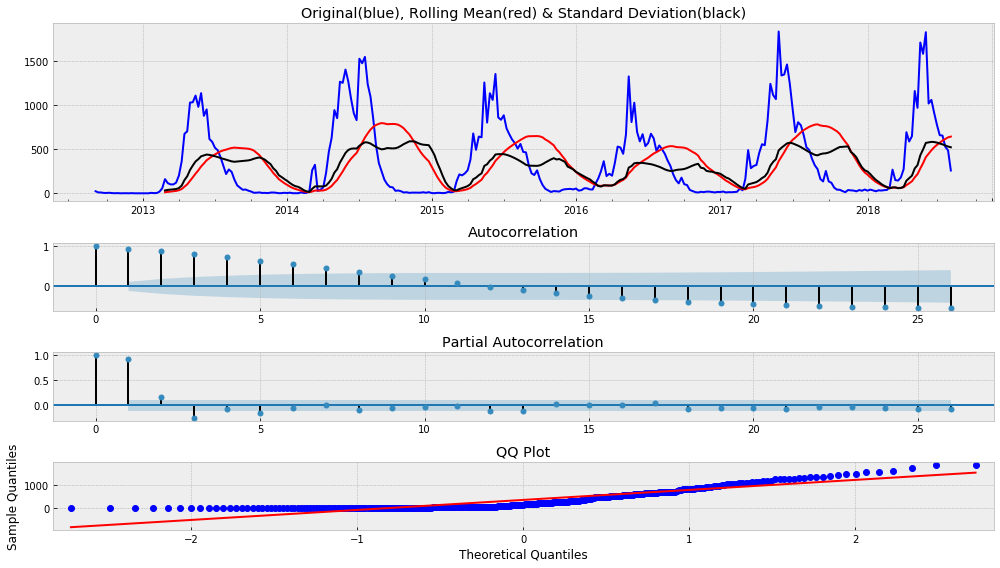

In [28]:
tsplot(df.sales, win=26, lags=26)

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).std()
  """


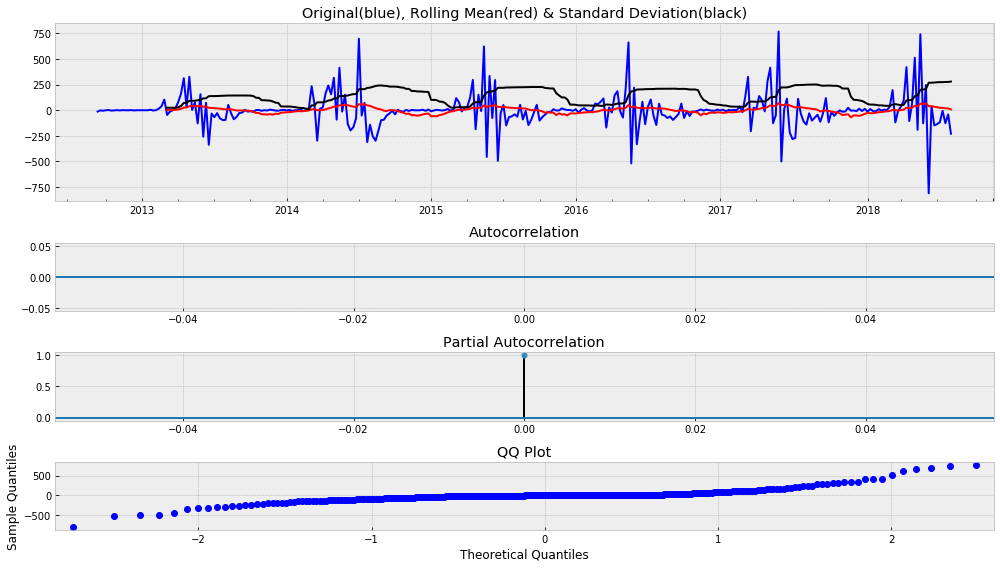

In [29]:
tsplot(df.first_difference, win=26, lags=26)

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).std()
  """


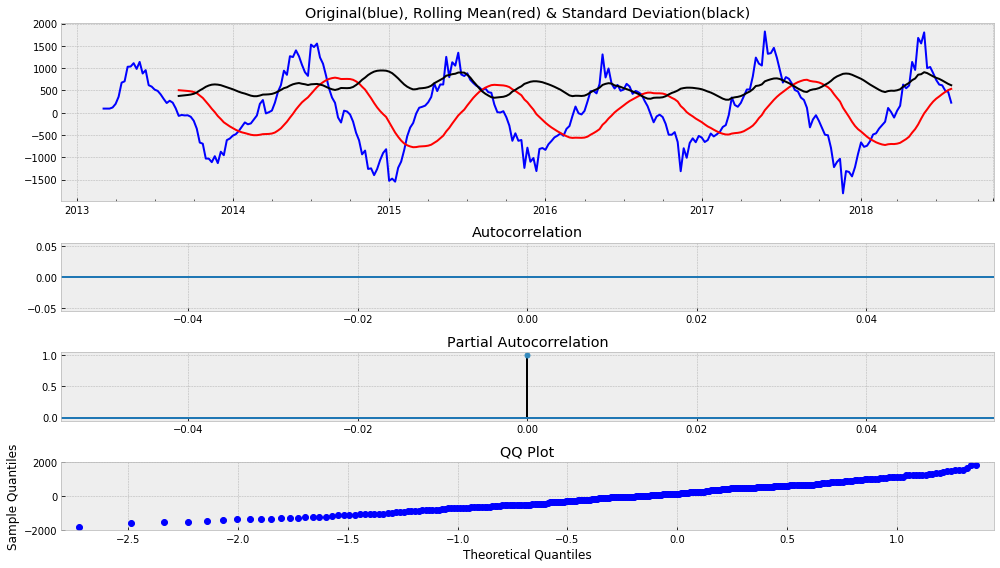

In [30]:
tsplot(df.half_seasonal_difference, win=26, lags=26)

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).std()
  """


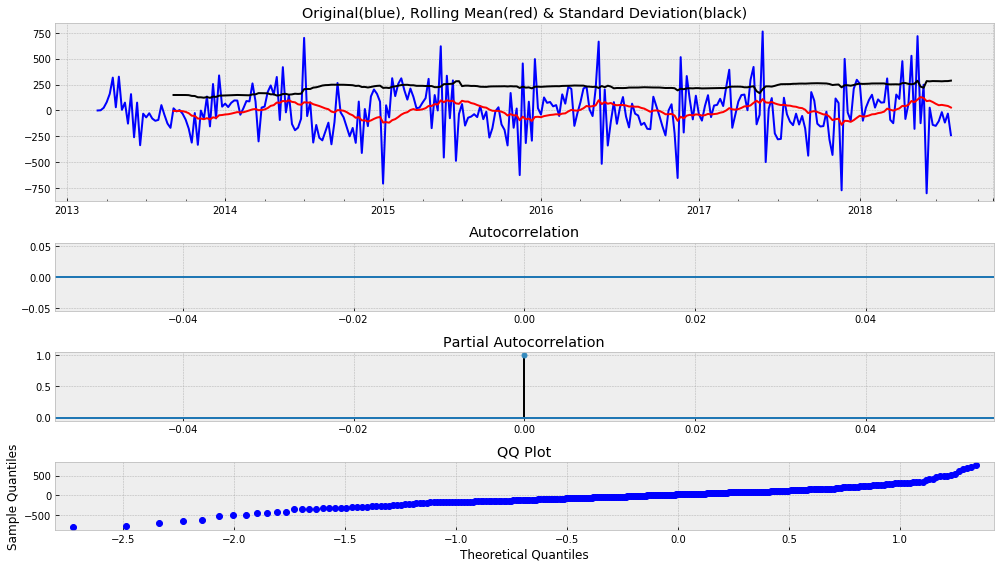

In [31]:
tsplot(df.half_seasonal_first_difference, win=26, lags=26)

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=52,center=False).std()
  """


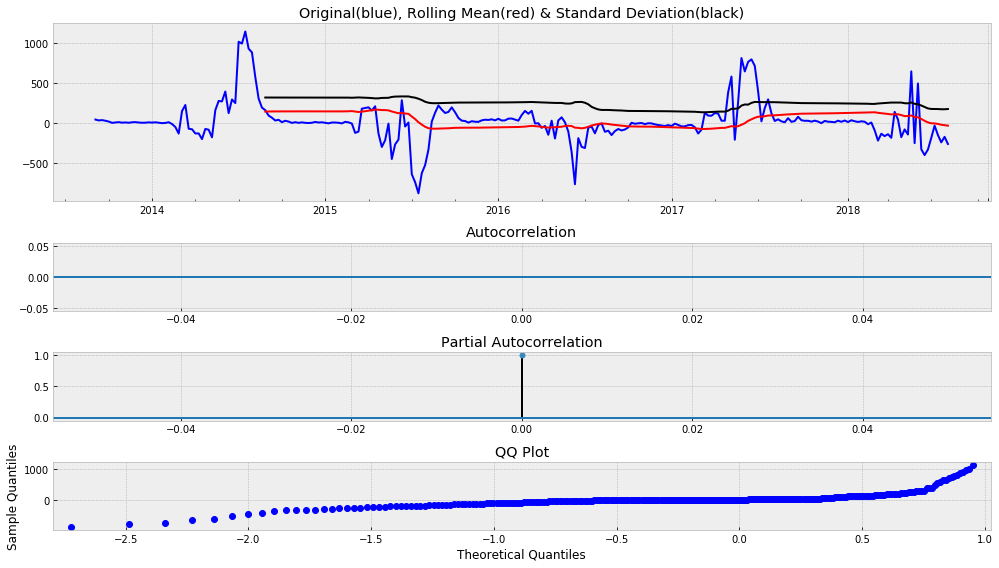

In [32]:
tsplot(df.seasonal_difference, win=52, lags=52)

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=52,center=False).std()
  """


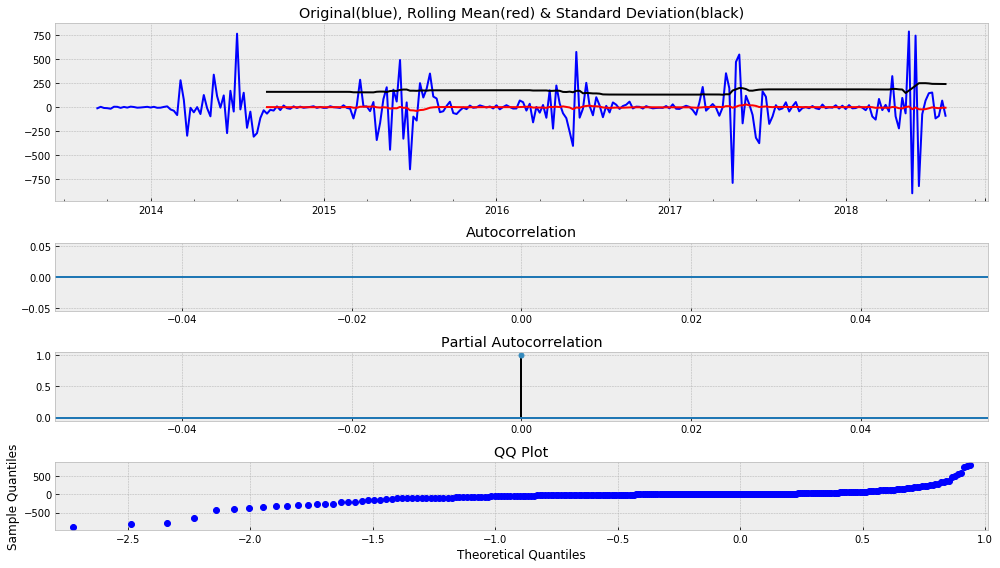

In [33]:
tsplot(df.seasonal_first_difference, win=52, lags=52) 

#### выводы

нет смысла использовать первые два графика в модели, все остальное можно по очереди попробовать

??? или в модель обязательно передавать исходный ряд

## SARIMA

???не до конца понял как выбирать компоненты модели - имею в виду изначальные P,Q, p, q

In [36]:
mod = sm.tsa.statespace.SARIMAX(df.sales, order=(10,0,3), seasonal_order=(0,0,0,26), trend = 'n')
results = mod.fit()
p(results.summary())

                           Statespace Model Results                           
Dep. Variable:                  sales   No. Observations:                  309
Model:              SARIMAX(10, 0, 3)   Log Likelihood               -1986.063
Date:                Wed, 29 Aug 2018   AIC                           4000.125
Time:                        11:50:25   BIC                           4052.392
Sample:                    09-09-2012   HQIC                          4021.022
                         - 08-05-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4903      0.660      0.743      0.458      -0.804       1.784
ar.L2          0.4627      0.185      2.495      0.013       0.099       0.826
ar.L3          0.8378      0.183      4.586      0.0

C:\Pythonn\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


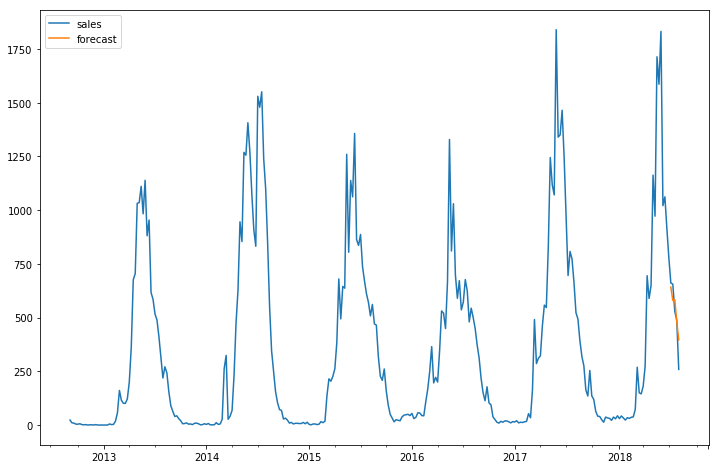

In [37]:
df['forecast'] = results.predict(start = 304, end= 315, dynamic= True)
df[['sales', 'forecast']].plot(figsize=(12, 8))
# plt.savefig('ts_df_predict.png', bbox_inches='tight')

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


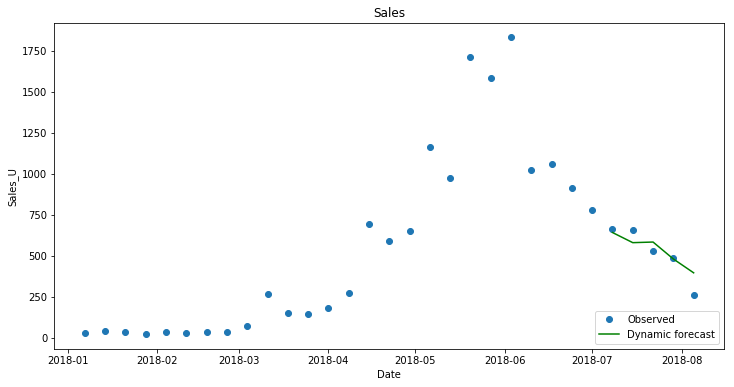

In [38]:
npredict =df.sales['2018'].shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 1
ax.set(title='Sales', xlabel='Date', ylabel='Sales_U')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'sales'], 'o', label='Observed')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'forecast'], 'g', label='Dynamic forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')
plt.savefig('ts_predict_compare.png', bbox_inches='tight')

### Подбор параметров SARIMAX

In [39]:
from scipy.optimize import minimize
import tqdm

In [40]:
ps = range(0, 3)
d= 1,
qs = range(0, 3)
Ps = range(0, 3)
D = 1,
Qs = range(0, 3)
S = [26, 52]

from itertools import product

parameters = product(ps, d, qs, Ps, D, Qs, S)
parameters_list = list(parameters)
len(parameters_list)

162

In [41]:
import warnings

??? на этом этапе и выдает ошибку сингулярности матриц, т.е. дальнейший код не работает

In [ ]:
%time
results = []
best_aic = float("inf")

for param in tqdm.tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(df.sales, order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3],param[4], param[5], param[6])).fit(disp=1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic

    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

In [ ]:
print(result_table.sort_values(by = 'aic', ascending=True).head())

In [ ]:
%%time
best_model = sm.tsa.statespace.SARIMAX(df.sales, order=(4, d, 3), 
                                        seasonal_order=(4, D, 1, 24)).fit(disp=-1)
print(best_model.summary()) 

In [ ]:
tsplot(best_model.resid[24:], lags=30)

In [ ]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+100), lmbda)
forecast = data.arima_model.append(forecast).values[-500:]
actual = data.Users.values[-400:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(data.dropna().Users, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

# Keras

## импорты

In [42]:
import keras

C:\Pythonn\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [43]:
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
#from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

import theano
theano.config.compute_test_value = "ignore"

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Pythonn\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [44]:
import copy

In [45]:
data = copy.deepcopy(df['sales'])

In [46]:
data.head()

2012-09-09    23
2012-09-16    10
2012-09-23     9
2012-09-30     4
2012-10-07     4
Name: sales, dtype: int64

## Классификация

In [47]:
def  shuffle_in_unison (a, b):

    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

хорошие результаты получали при трейн/тест 90/10(дефолт) и 80/20
окно изменили на 26 с 52 - это увеличило точность на 10% в среднем и без переобучения
dense input - 64 по дефолту. поменял зачем-то, надо потестировать

In [48]:
WINDOW = 26
EMB_SIZE = 1
STEP = 1
FORECAST = 5


X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

    except Exception as e:
        print (e)
        break

    X.append(x_i)
    Y.append(y_i)

#X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

index out of bounds


## создание модели

In [49]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dropout(0.65))
model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = Nadam(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
model.compile(optimizer=opt, 
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 350, 
          batch_size = 15, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/350
 - 1s - loss: 7419319.4100 - acc: 0.5600 - val_loss: 2654294.6339 - val_acc: 0.7857

Epoch 00001: val_loss improved from inf to 2654294.63393, saving model to test.hdf5
Epoch 2/350
 - 0s - loss: 3869480.0600 - acc: 0.6480 - val_loss: 1661406.4598 - val_acc: 0.6786

Epoch 00002: val_loss improved from 2654294.63393 to 1661406.45982, saving model to test.hdf5
Epoch 3/350
 - 0s - loss: 2184003.2800 - acc: 0.6200 - val_loss: 1129223.8594 - val_acc: 0.6786

Epoch 00003: val_loss improved from 1661406.45982 to 1129223.85938, saving model to test.hdf5
Epoch 4/350
 - 0s - loss: 1390769.0675 - acc: 0.6440 - val_loss: 836187.6350 - val_acc: 0.6786

Epoch 00004: val_loss improved from 1129223.85938 to 836187.63504, saving model to test.hdf5
Epoch 5/350
 - 0s - loss: 1003307.7338 - acc: 0.6360 - val_loss: 648276.8030 - val_acc: 0.6429

Epoch 00005: val_loss improved from 836187.63504 to 648276.80301, saving model to test.hdf5
Epoch 6/350
 - 

Epoch 88/350
 - 0s - loss: 41052.5120 - acc: 0.7360 - val_loss: 29689.2777 - val_acc: 0.8571

Epoch 00088: val_loss improved from 30222.53959 to 29689.27769, saving model to test.hdf5
Epoch 89/350
 - 0s - loss: 40046.9507 - acc: 0.6920 - val_loss: 28956.7814 - val_acc: 0.8571

Epoch 00089: val_loss improved from 29689.27769 to 28956.78142, saving model to test.hdf5
Epoch 90/350
 - 0s - loss: 39087.9545 - acc: 0.7240 - val_loss: 28142.8526 - val_acc: 0.8214

Epoch 00090: val_loss improved from 28956.78142 to 28142.85256, saving model to test.hdf5
Epoch 91/350
 - 0s - loss: 37973.1254 - acc: 0.7240 - val_loss: 27530.9576 - val_acc: 0.7857

Epoch 00091: val_loss improved from 28142.85256 to 27530.95755, saving model to test.hdf5
Epoch 92/350
 - 0s - loss: 37392.4080 - acc: 0.6920 - val_loss: 26879.3005 - val_acc: 0.8929

Epoch 00092: val_loss improved from 27530.95755 to 26879.30047, saving model to test.hdf5
Epoch 93/350
 - 0s - loss: 36105.1825 - acc: 0.6920 - val_loss: 26247.3403 - val


Epoch 00131: val_loss improved from 12017.46484 to 11675.98678, saving model to test.hdf5
Epoch 132/350
 - 0s - loss: 14247.9695 - acc: 0.7080 - val_loss: 11480.6914 - val_acc: 0.8929

Epoch 00132: val_loss improved from 11675.98678 to 11480.69138, saving model to test.hdf5
Epoch 133/350
 - 0s - loss: 14053.6134 - acc: 0.7000 - val_loss: 11254.2915 - val_acc: 0.8929

Epoch 00133: val_loss improved from 11480.69138 to 11254.29150, saving model to test.hdf5
Epoch 134/350
 - 0s - loss: 13607.5125 - acc: 0.6840 - val_loss: 10984.2275 - val_acc: 0.8929

Epoch 00134: val_loss improved from 11254.29150 to 10984.22751, saving model to test.hdf5
Epoch 135/350
 - 0s - loss: 13415.7422 - acc: 0.6840 - val_loss: 10825.9492 - val_acc: 0.8929

Epoch 00135: val_loss improved from 10984.22751 to 10825.94920, saving model to test.hdf5
Epoch 136/350
 - 0s - loss: 13061.6207 - acc: 0.7320 - val_loss: 10613.0246 - val_acc: 0.9286

Epoch 00136: val_loss improved from 10825.94920 to 10613.02461, saving mod

Epoch 00220: val_loss improved from 2041.07857 to 1977.45754, saving model to test.hdf5
Epoch 221/350
 - 0s - loss: 2039.3740 - acc: 0.7280 - val_loss: 1989.7919 - val_acc: 0.8571

Epoch 00221: val_loss did not improve from 1977.45754
Epoch 222/350
 - 0s - loss: 2003.9416 - acc: 0.7240 - val_loss: 1937.7234 - val_acc: 0.8571

Epoch 00222: val_loss improved from 1977.45754 to 1937.72340, saving model to test.hdf5
Epoch 223/350
 - 0s - loss: 1957.9105 - acc: 0.6840 - val_loss: 1876.4774 - val_acc: 0.8929

Epoch 00223: val_loss improved from 1937.72340 to 1876.47738, saving model to test.hdf5
Epoch 224/350
 - 0s - loss: 1911.8727 - acc: 0.7440 - val_loss: 1857.2755 - val_acc: 0.8929

Epoch 00224: ReduceLROnPlateau reducing learning rate to 0.0004304672533180565.

Epoch 00224: val_loss improved from 1876.47738 to 1857.27547, saving model to test.hdf5
Epoch 225/350
 - 0s - loss: 1888.4516 - acc: 0.7200 - val_loss: 1803.4317 - val_acc: 0.8929

Epoch 00225: val_loss improved from 1857.27547 t


Epoch 00311: val_loss did not improve from 342.12924
Epoch 312/350
 - 0s - loss: 307.5130 - acc: 0.7520 - val_loss: 331.0287 - val_acc: 0.8929

Epoch 00312: val_loss improved from 342.12924 to 331.02875, saving model to test.hdf5
Epoch 313/350
 - 0s - loss: 296.8912 - acc: 0.7960 - val_loss: 322.7420 - val_acc: 0.8571

Epoch 00313: val_loss improved from 331.02875 to 322.74200, saving model to test.hdf5
Epoch 314/350
 - 0s - loss: 294.1103 - acc: 0.8040 - val_loss: 317.2045 - val_acc: 0.8571

Epoch 00314: val_loss improved from 322.74200 to 317.20451, saving model to test.hdf5
Epoch 315/350
 - 0s - loss: 287.7485 - acc: 0.7720 - val_loss: 317.9199 - val_acc: 0.7500

Epoch 00315: val_loss did not improve from 317.20451
Epoch 316/350
 - 0s - loss: 285.6234 - acc: 0.7720 - val_loss: 304.3944 - val_acc: 0.8929

Epoch 00316: val_loss improved from 317.20451 to 304.39437, saving model to test.hdf5
Epoch 317/350
 - 0s - loss: 274.6520 - acc: 0.7760 - val_loss: 301.2644 - val_acc: 0.8929

Epo

## графики

??? построить графики как auc-roc в керасе

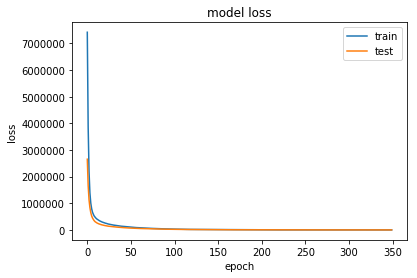

In [51]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

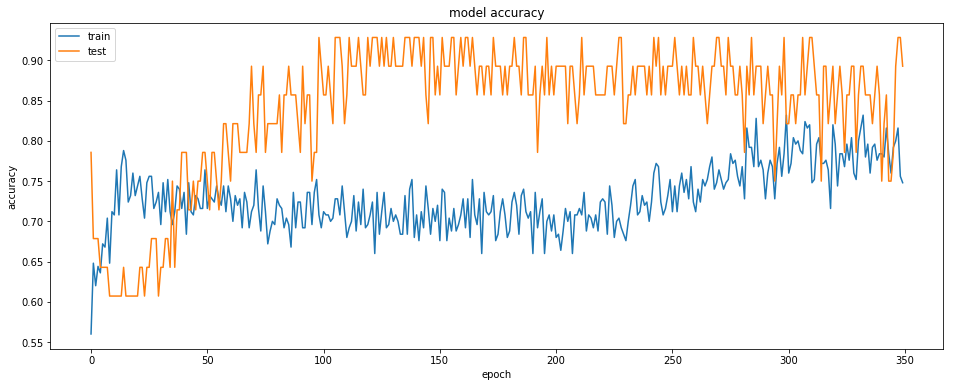

In [52]:
plt.figure(figsize=(16,6))
plt.plot(history.history['acc'])
#print (history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

классификатор переобучается на 300 Эпохах

Важно. чем выше дропаут, тем лучше показатель. дропауты 0.1, 0.3 дают результат около 80%

In [53]:
plt.savefig('batch15_nepochs150_classification_with_dropout.png', bbox_inches='tight')

Важно. Наличие нормализации на втором слое существенно улучшило прогноз по регрессии

## Регрессия

In [54]:
WINDOW = 26
STEP = 1
FORECAST = 5


X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        y = []

    except Exception as e:
        print (e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

index out of bounds


In [55]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.0001)))
#model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dropout(0.5))
model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(1))
model.add(Activation('linear'))

opt = Nadam(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
model.compile(optimizer=opt, 
              loss= 'mean_squared_error',
              metrics=['mse'])

In [56]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 150, 
          batch_size = 15, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/150
 - 1s - loss: 303701.8691 - mean_squared_error: 303701.7092 - val_loss: 614491.4994 - val_mean_squared_error: 614491.3744


C:\Pythonn\Anaconda3\lib\site-packages\keras\callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



Epoch 00001: val_loss improved from inf to 614491.49944, saving model to test.hdf5
Epoch 2/150
 - 0s - loss: 296342.8666 - mean_squared_error: 296342.6092 - val_loss: 598217.6518 - val_mean_squared_error: 598217.3527

Epoch 00002: val_loss improved from 614491.49944 to 598217.65179, saving model to test.hdf5
Epoch 3/150
 - 0s - loss: 292040.3078 - mean_squared_error: 292039.9092 - val_loss: 585190.0541 - val_mean_squared_error: 585189.6138

Epoch 00003: val_loss improved from 598217.65179 to 585190.05413, saving model to test.hdf5
Epoch 4/150
 - 0s - loss: 287629.1938 - mean_squared_error: 287628.6748 - val_loss: 575723.4615 - val_mean_squared_error: 575722.9258

Epoch 00004: val_loss improved from 585190.05413 to 575723.46150, saving model to test.hdf5
Epoch 5/150
 - 0s - loss: 283397.8276 - mean_squared_error: 283397.2314 - val_loss: 564904.1066 - val_mean_squared_error: 564903.4297

Epoch 00005: val_loss improved from 575723.46150 to 564904.10658, saving model to test.hdf5
Epoch 6/


Epoch 00075: val_loss did not improve from 108030.07743
Epoch 76/150
 - 0s - loss: 42015.7311 - mean_squared_error: 42013.0419 - val_loss: 115095.4962 - val_mean_squared_error: 115093.2409

Epoch 00076: val_loss did not improve from 108030.07743
Epoch 77/150
 - 0s - loss: 39510.5016 - mean_squared_error: 39507.7791 - val_loss: 115218.2206 - val_mean_squared_error: 115215.7853

Epoch 00077: val_loss did not improve from 108030.07743
Epoch 78/150
 - 0s - loss: 44533.2540 - mean_squared_error: 44530.4681 - val_loss: 111259.0206 - val_mean_squared_error: 111256.7234

Epoch 00078: val_loss did not improve from 108030.07743
Epoch 79/150
 - 0s - loss: 40343.5770 - mean_squared_error: 40340.8266 - val_loss: 109318.0689 - val_mean_squared_error: 109315.6497

Epoch 00079: val_loss did not improve from 108030.07743
Epoch 80/150
 - 0s - loss: 45774.2815 - mean_squared_error: 45771.4925 - val_loss: 106750.8677 - val_mean_squared_error: 106748.3590

Epoch 00080: val_loss improved from 108030.07743 

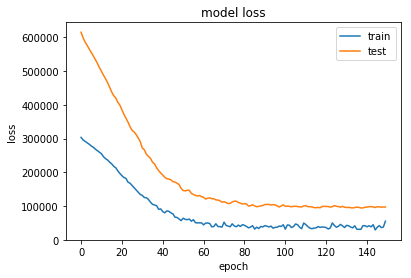

In [57]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

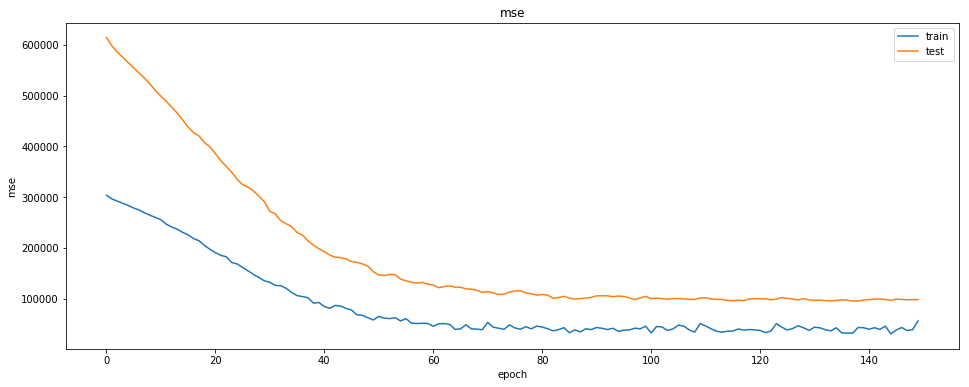

In [58]:
plt.figure(figsize=(16,6))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

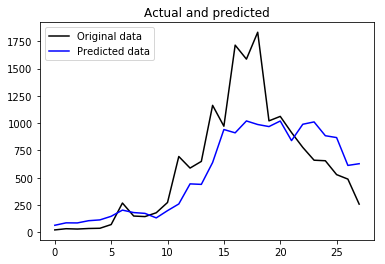

In [59]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

ВЫВОД. На текущих условиях прогноз не схватывает размах дисперсии, хотя тренд, в целом, угадывается

## Гиперопт

In [60]:
from keras.wrappers.scikit_learn import KerasRegressor

In [61]:
def mdl (X_train, X_test, Y_train, Y_test):
        model = Sequential()
        model.add(Dense(164, input_dim=WINDOW,
                        activity_regularizer=regularizers.l2(0.0001)))
        #model.add(BatchNormalization())
        model.add(LeakyReLU())

        #model.add(Dropout(0.5))
        model.add(Dense(360,
                        activity_regularizer=regularizers.l2(0.0001)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Dense(1))
        model.add(Activation('linear'))

        opt = Nadam(lr=0.001)

        reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
        checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
        model.compile(optimizer=opt, 
                      loss= 'mean_squared_error',
                      metrics=['mse'])
        return model

In [62]:
modl = KerasRegressor(build_fn=mdl(X_train, X_test, Y_train, Y_test), verbose = 1)

In [63]:
batch_size = [10, 20]
epochs = [10, 12]
param_grid = dict(batch_size=batch_size, epochs=epochs)

In [64]:
from sklearn.model_selection import GridSearchCV

In [65]:
grid = GridSearchCV(estimator=modl, param_grid=param_grid, n_jobs=-1)

In [66]:
grid_result = grid.fit(X_train, Y_train)

TypeError: can't pickle _thread.RLock objects

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [67]:
import hyperas

In [68]:
from hyperopt import Trials, STATUS_OK, tpe
from keras.models import Sequential
from keras.utils import np_utils

from hyperas import optim
from hyperas.distributions import choice, uniform



def create_model(x_train, y_train, x_test, y_test):
    """
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    """
    model = Sequential()
    model.add(Dense(164, input_dim=WINDOW, activity_regularizer=regularizers.l2(0.0001)))
#model.add(BatchNormalization())
    model.add(LeakyReLU())

#model.add(Dropout(0.5))
    model.add(Dense(360, activity_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dense(1))
    model.add(Activation('relu'))

    opt = Nadam(lr=0.001)

    reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
    checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mse'])

    model.fit(X_train, Y_train, 
          nb_epoch = 150, 
          batch_size = 15, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

    score, acc = model.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [56]:
if __name__ == '__main__':
    best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                          notebook_name='diplom 1st sent-Copy1')
    X_train, Y_train, X_test, Y_test = data()
    print('Evalutation of best performing model:')
    print(best_model.evaluate(X_test, Y_test))
    print('Best performing model chosen hyper-parameters:')
    print(best_run)

SyntaxError: EOL while scanning string literal (<unknown>, line 121)

??? выдает ошибку кодировки, которую никак не получается удалить

# decision tree

## imports, data

In [34]:
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [35]:
import copy

In [36]:
data2 = copy.deepcopy(df)

In [37]:
data2.head()

,ind,dates,sales,AUP_RUR,AUP_RUR_RRP,AUP+bonus,sales1,first_difference,half_seasonal_difference,half_seasonal_first_difference,seasonal_difference,seasonal_first_difference
2012-09-09,1,2012-09-09,23,5658.513739,9619.448357,6612.109391,345,NaN,NaN,NaN,NaN,NaN
2012-09-16,2,2012-09-16,10,6065.175200,10238.858811,6762.978200,150,-13.0,NaN,NaN,NaN,NaN
2012-09-23,3,2012-09-23,9,5876.925926,9058.186700,6231.744815,135,-1.0,NaN,NaN,NaN,NaN
2012-09-30,4,2012-09-30,4,5319.947500,9415.000000,6163.250000,60,-5.0,NaN,NaN,NaN,NaN
2012-10-07,5,2012-10-07,4,6731.930000,9415.000000,6807.750000,60,0.0,NaN,NaN,NaN,NaN


In [38]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 309 entries, 2012-09-09 to 2018-08-05
Data columns (total 12 columns):
ind                               309 non-null int64
dates                             309 non-null object
sales                             309 non-null int64
AUP_RUR                           309 non-null float64
AUP_RUR_RRP                       309 non-null float64
AUP+bonus                         309 non-null float64
sales1                            309 non-null int64
first_difference                  308 non-null float64
half_seasonal_difference          283 non-null float64
half_seasonal_first_difference    282 non-null float64
seasonal_difference               257 non-null float64
seasonal_first_difference         256 non-null float64
dtypes: float64(8), int64(3), object(1)
memory usage: 31.4+ KB


## features addition

? имеет ли смысл добавление среднего - скорее всего, да, но нужно будет сначала предсказать среднее, а потом, на основе этого предсказания уже и остальное предсказывать

??? может быть предсказывать не значение, а процентное изменение на основе деревьев?

In [39]:
data2['season'] = data2.sales

In [40]:
data2['season'].loc['2012':'2013-03-01'] = "aw"
data2['season'].loc['2013-03-01':'2013-09-01'] = "ss"
data2['season'].loc['2013-09-01':'2014-03-01'] = "aw"
data2['season'].loc['2014-03-01':'2014-09-01'] = "ss"
data2['season'].loc['2014-09-01':'2015-03-01'] = "aw"
data2['season'].loc['2015-03-01':'2015-09-01'] = "ss"
data2['season'].loc['2015-09-01':'2016-03-01'] = "aw"
data2['season'].loc['2016-03-01':'2016-09-01'] = "ss"
data2['season'].loc['2016-09-01':'2017-03-01'] = "aw"
data2['season'].loc['2017-03-01':'2017-09-01'] = "ss"
data2['season'].loc['2017-09-01':'2018-03-01'] = "aw"
data2['season'].loc['2018-03-01':'2018-09-01'] = "ss"

C:\Pythonn\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [43]:
data2['Last_Week_Sales'] = data2['sales'].shift()
data2['Last_Week_Diff'] = data2['Last_Week_Sales'].diff()
#data2 = data2.dropna()
#data2.head()

In [44]:
data2.head()

,ind,dates,sales,AUP_RUR,AUP_RUR_RRP,AUP+bonus,sales1,first_difference,half_seasonal_difference,half_seasonal_first_difference,seasonal_difference,seasonal_first_difference,season,Last_Week_Sales,Last_Week_Diff
2012-09-09,1,2012-09-09,23,5658.513739,9619.448357,6612.109391,345,NaN,NaN,NaN,NaN,NaN,aw,NaN,NaN
2012-09-16,2,2012-09-16,10,6065.175200,10238.858811,6762.978200,150,-13.0,NaN,NaN,NaN,NaN,aw,23.0,NaN
2012-09-23,3,2012-09-23,9,5876.925926,9058.186700,6231.744815,135,-1.0,NaN,NaN,NaN,NaN,aw,10.0,-13.0
2012-09-30,4,2012-09-30,4,5319.947500,9415.000000,6163.250000,60,-5.0,NaN,NaN,NaN,NaN,aw,9.0,-1.0
2012-10-07,5,2012-10-07,4,6731.930000,9415.000000,6807.750000,60,0.0,NaN,NaN,NaN,NaN,aw,4.0,-5.0


In [2]:
data2['weeks'] = list(range(len(data2.index)))

NameError: name 'data2' is not defined

In [91]:
data2.index = list(range(len(data2.index)))

In [94]:
data2.drop(['AUP_RUR', 'AUP_RUR_RRP', 'AUP+bonus'], axis = 1, inplace = True)

In [96]:
data2.drop('forecast', axis = 1, inplace = True)

In [100]:
data3 = pd.get_dummies(data2)

In [101]:
Y = pd.DataFrame(data3.sales)

In [102]:
X = data3.drop('sales', axis = 1)

## функция ошибки, baseline

нужно использовать MAE, RMSE, MSE, R2

In [103]:
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score
from math import sqrt

def rmse(ytrue,ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred));
def mse(ytrue,ypred):
    return (mean_squared_error(ytrue, ypred));
def rmsle(ytrue, ypred):
    return mean_squared_log_error(ytrue, ypred);
def mae (ytrue,ypred):
    return mean_absolute_error(ytrue,ypred);
def r2 (ytrue,ypred):
    return r2_score(ytrue,ypred);
def evs (ytrue,ypred):
    return explained_variance_score(ytrue,ypred);
def medae (ytrue,ypred):
    return median_absolute_error(ytrue,ypred)

есть ощущение, что просто rmse применять бессмысленно, нужно сравнивать с чем-то

еще есть метрика ошибки 

In [104]:
mean_error = []
for week in range(300,307):
    train = data3[data3['weeks'] < week]
    val = data3[data3['weeks'] == week]
    
    p = val['Last_Week_Sales'].values
    
    error = mse(val['sales'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 300 - Error 657721.00000
Week 301 - Error 1681.00000
Week 302 - Error 21904.00000
Week 303 - Error 18496.00000
Week 304 - Error 13689.00000
Week 305 - Error 25.00000
Week 306 - Error 16129.00000
Mean Error = 104235.00000


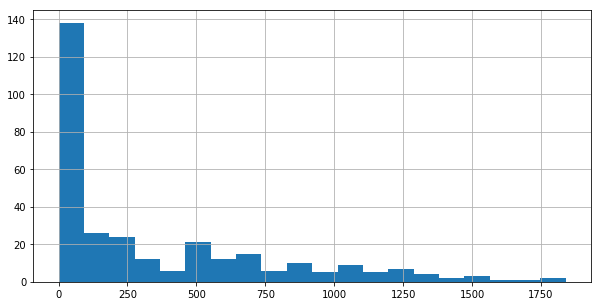

In [106]:
data3['sales'].hist(bins=20, figsize=(10,5))

## first run

НА ВСЕМ ПРОВЕРИТЬ НА МАЛЕНЬКИХ ДАННЫХ - ВЕЗДЕ ПОКАЗАТЬ ЛОГ ОБУЧЕНИЯ, КАК В НЕЙРОНКАХ - LEARNING RATE

In [107]:
mean_error = []
for week in range(300,307):
    train = data3[data3['weeks'] < week]
    val = data3[data3['weeks'] == week]
    
    xtr, xts = train.drop(['sales'], axis=1), val.drop(['sales'], axis=1)
    ytr, yts = train['sales'].values, val['sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000,  criterion='mse',n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = mse(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [ ]:
mdl = RandomForestRegressor(n_estimators=1000,  criterion='mse',n_jobs=-1, random_state=0)
mdl.fit(X_train, Y_train)
    
p = mdl.predict(X_test)

In [ ]:
p

In [ ]:
mean_squared_error(Y_test, p)

In [ ]:
# графическое отображение
plt.scatter(Y_test,p)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [ ]:
import seaborn as sns

In [ ]:
# график ошибок
sns.distplot((Y_test-p),bins=50);

In [ ]:
mean_error = []
for week in range(290,307):
    train = data2[data2['weeks'] < week]
    val = data2[data2['weeks'] == week]
    
    xtr, xts = train.drop(['sales'], axis=1), val.drop(['sales'], axis=1)
    ytr, yts = train['sales'].values, val['sales'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    error = mae(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

## GS

In [ ]:
# задаем параметры для поиска

params =  {
    'boosting_type': ['gbdt', 'rf', 'dart','goss' ],
    #'num_leaves': list( range(2, 5)),   
    #'learning_rate': ['0.01','0.1','0.9'],
    #'max_depth' : list(range(1,10)),
    #'n_estimators' : ['1','10','25','50', '75', '100']    
} 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import cross_validation

??? первый раз вижу такую ошибку, не понимаю как исправить, чтобы запустить gridsearch

In [ ]:
# прогоняем через GS регрессию с заданными параметрами и кроссвалидацией, тренируем модель
gs = GridSearchCV(LGBMRegressor(), params,  scoring = 'neg_mean_squared_error', cv=10, return_train_score = True )
gs.fit( xtr, ytr)

In [ ]:
# выводим наилучшие параметры 
best_feat = gs.best_params_
best_feat

In [ ]:
# создаем и тренируем модель, затем по ней выводим функцию
model2 = LogisticRegression(C = 14, max_iter = 4, penalty = 'l1')
model2.fit(X_train, y_train)

predictions2 = model2.predict_proba(X_train)
zip( predictions2[:, 1], y_train )
model2.score(X_test, y_test)


### Hyperopt

здесь будет гиперопт